<a href="https://colab.research.google.com/github/Nattawat1409/PMU-B-PersonalAI/blob/main/PMUB_Personal_AI_Image_classification_EfficientNetB5_Nattawat_Ruensumrit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs Dogs : Image Classification using EfficienNet

## Data Description

**The training archive contains 25,000 images of dogs and cats.**


## Install

In [5]:
!pip install efficientnet
!pip install pandas==1.5.3
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 77.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.3 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1

## Loading Libraries

> TensorFlow

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras import callbacks
from keras.callbacks import Callback
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [9]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

## Data Extraction

In [10]:
data_dir = '/content/sample_data'
%cd '/content/sample_data'
!pwd

/content/sample_data
/content/sample_data


In [11]:
path_to_downloaded_file = tf.keras.utils.get_file(
    origin=dataset_url,
    extract=True,
)

824887076/824887076 [==============================] - 11s 0us/step


In [12]:
path_to_downloaded_file

'/root/.keras/datasets/kagglecatsanddogs_5340.zip'

In [13]:
import zipfile

with zipfile.ZipFile(path_to_downloaded_file, 'r') as zipp:
    zipp.extractall(data_dir)

In [14]:
import glob

Cat_count = len(list(glob.glob(f'{data_dir}/PetImages/Cat/*.jpg')))
print('Cat: ', Cat_count)

Dog_count = len(list(glob.glob(f'{data_dir}/PetImages/Dog/*.jpg')))
print('Dog: ', Dog_count)

Cat:  12500
Dog:  12500


### Loading Images in a Dataframe

In [15]:
import pandas as pd
import glob
df_dada = pd.DataFrame(columns=['filename', 'label'])
list_dir = ["Cat", "Dog"]
for label in list_dir:
    filenames = list(glob.glob(f'{data_dir}/PetImages/{label}/*.jpg'))
    #labels = [x.split("/")[3] for x in filenames]
    data = pd.DataFrame({"filename": filenames, "label": label})
    data = data.iloc[:1250,]

    df_dada = df_dada.append(data)

print(df_dada.shape)
df_dada.head()

(2500, 2)


<ipython-input-15-d164dbcca542>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dada = df_dada.append(data)
<ipython-input-15-d164dbcca542>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dada = df_dada.append(data)


filename label
0   /content/sample_data/PetImages/Cat/9508.jpg   Cat
1    /content/sample_data/PetImages/Cat/621.jpg   Cat
2   /content/sample_data/PetImages/Cat/8825.jpg   Cat
3   /content/sample_data/PetImages/Cat/3714.jpg   Cat
4  /content/sample_data/PetImages/Cat/12054.jpg   Cat

## Data Exploration

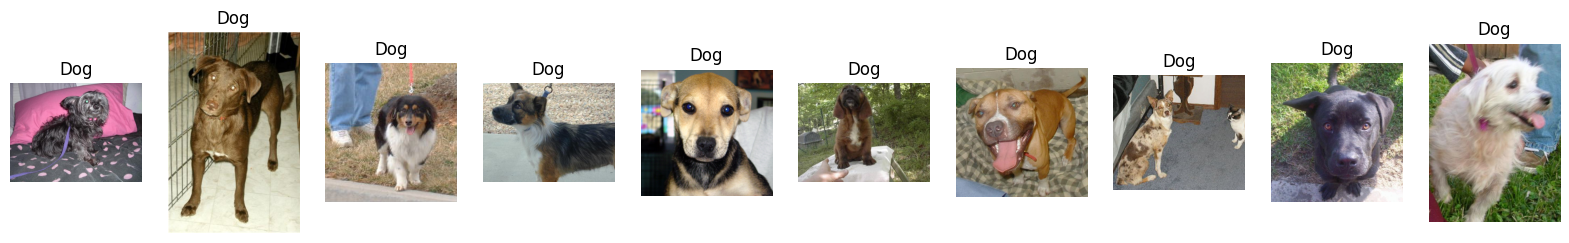

In [16]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Dog/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

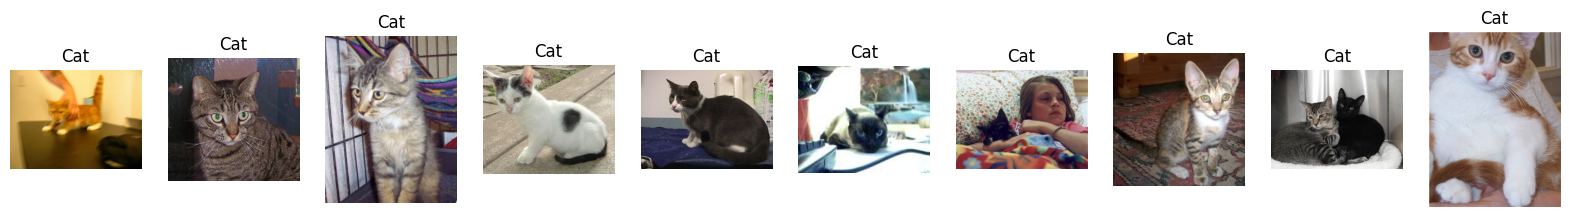

In [17]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Cat/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

### Train Test Split

In [18]:
# train test split using dataframe

labels = df_dada['label']

X_train, X_temp = train_test_split(df_dada, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (2000, 2)
The shape of test data (250, 2)
The shape of validation data (250, 2)


<ipython-input-19-418fb063fcee>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
<ipython-input-19-418fb063fcee>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
<ipython-input-19-418fb063fcee>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',w

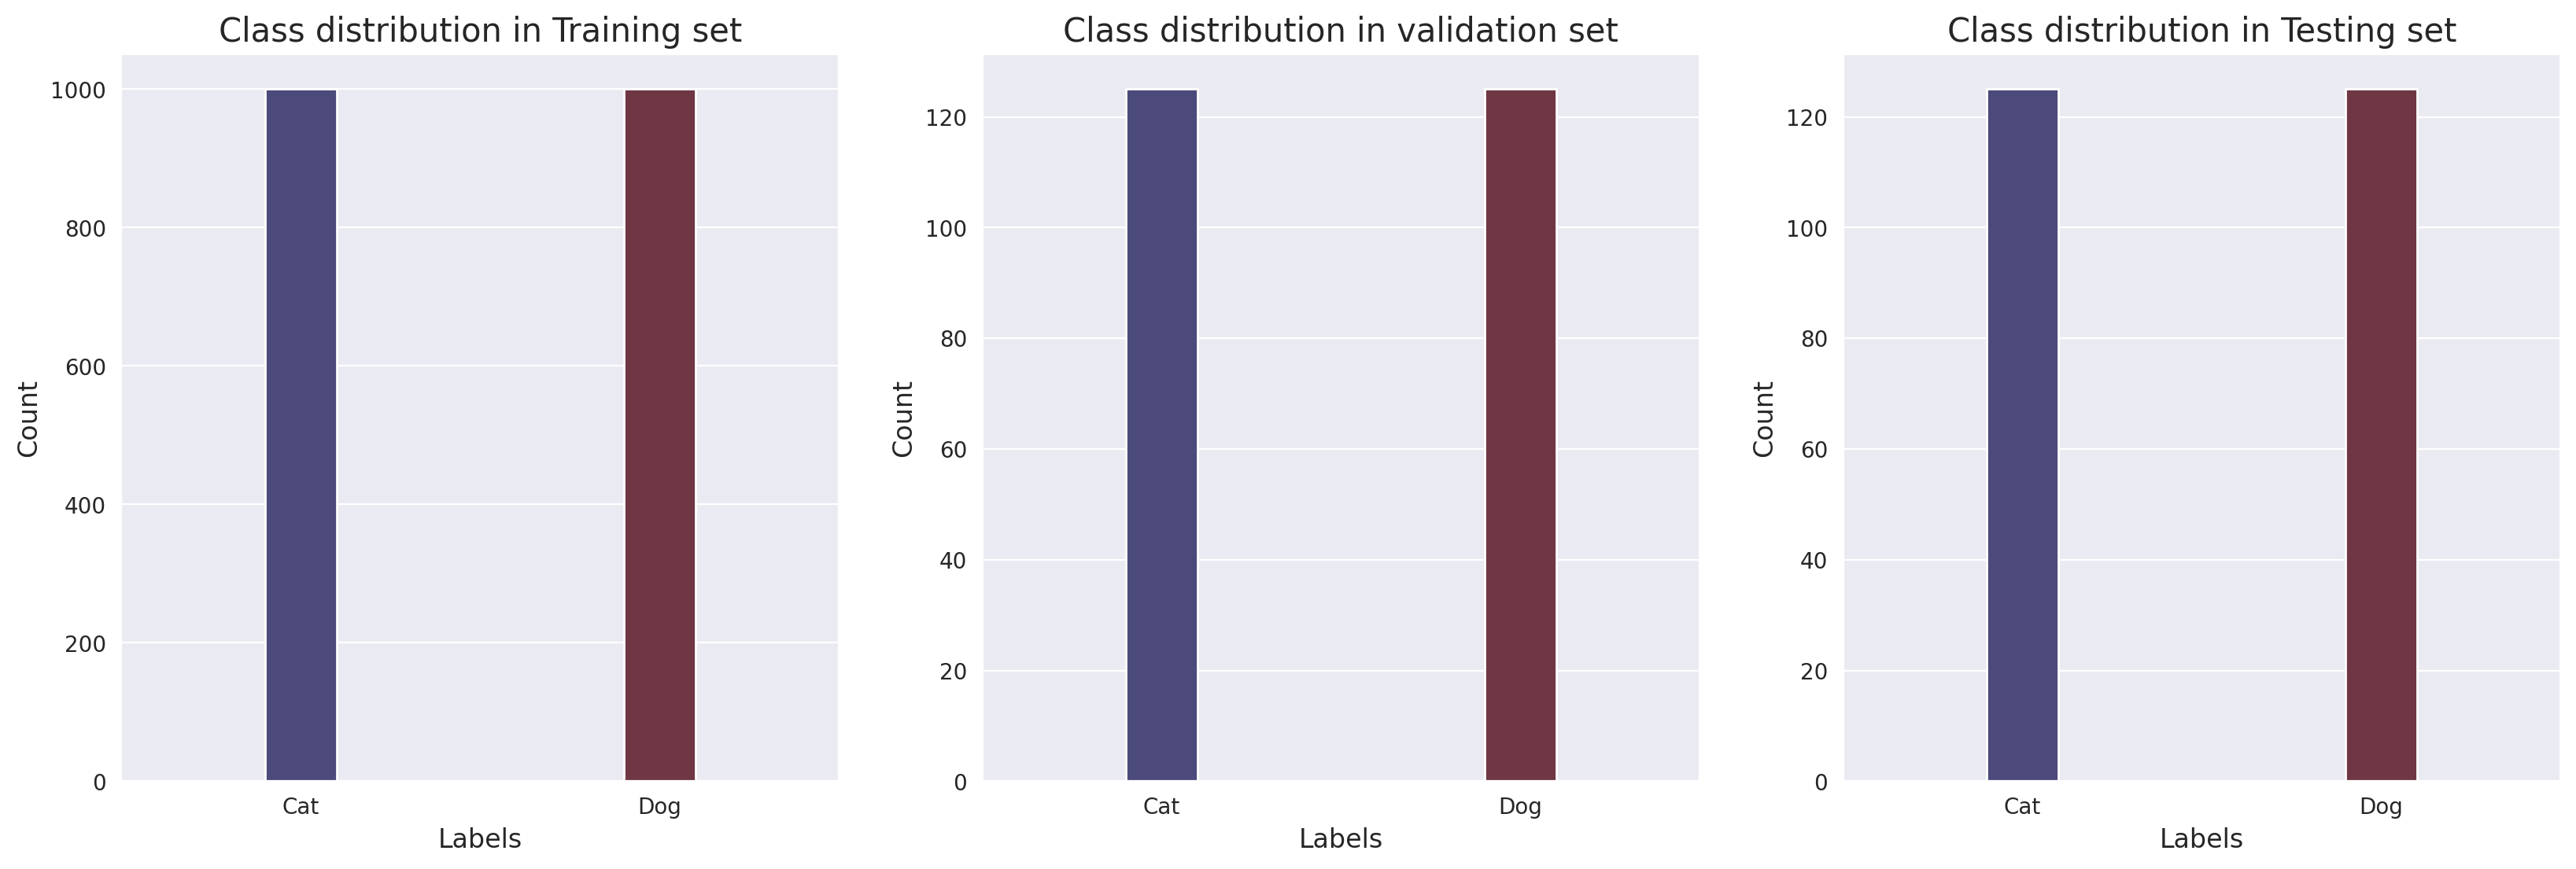

In [19]:
labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

### Data Preparation

In [20]:
# parameters
target_size = (456, 456)
batch_size = 16

### Image Data Generator

-  The data for will used by flow_from_dataframe.

- The batch size is 16 and the image size is (456, 456).

In [21]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'nearest',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = None,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = batch_size,
                                                    target_size = target_size,
                                                    class_mode='categorical',
                                                    color_mode= 'rgb'
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = None,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = batch_size,
                                                 target_size = target_size,
                                                 class_mode='categorical',
                                                 color_mode= 'rgb'
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = None,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = batch_size,
                                                  target_size = target_size,
                                                  class_mode='categorical',
                                                  color_mode= 'rgb'
                                                 )

Found 2000 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


In [23]:
#label
labels = (train_generator.class_indices)
print(labels)

{'Cat': 0, 'Dog': 1}


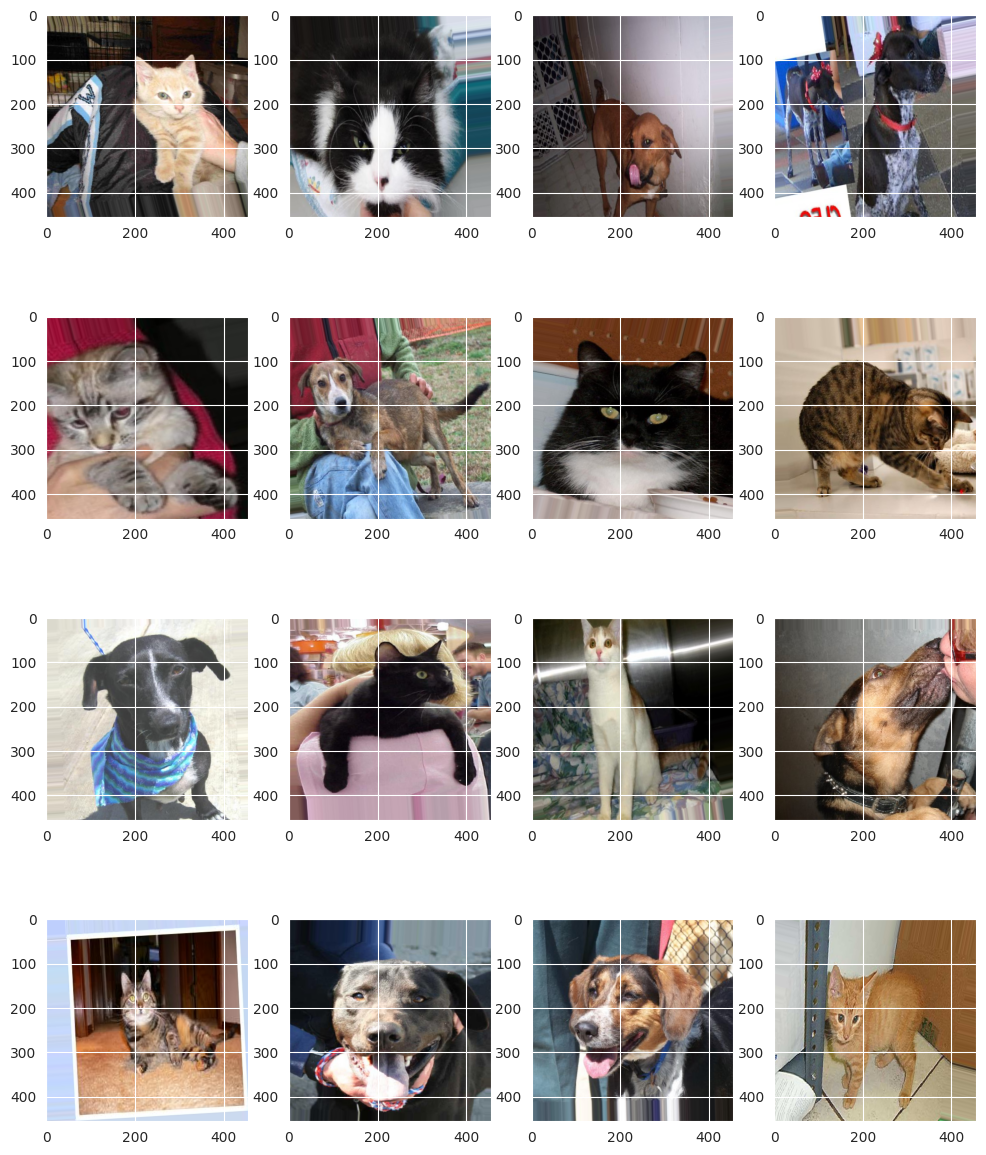

In [24]:
import cv2
import PIL
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(12, 15))
columns = 4
rows = 4
x, y = train_generator.next()
for i in range(0, columns*rows):
    image = x[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
plt.show()

## EfficienNet Model

In [25]:
# loading pretrained conv base model
from efficientnet.keras import EfficientNetB5 as Net

input_shape = (456, 456, 3)
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)
print(f"Input Shape: {input_shape}")

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation='softmax',name = 'predict_Cat_Dog')(dropout_layer)

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

115515256/115515256 [==============================] - 1s 0us/step
Input Shape: (456, 456, 3)


In [26]:
### Unfreeze FC layer
print('[INFO]: This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))
print('[INFO]: Freezing hidden layers...')
for layer in conv_base.layers:
    layer.trainable = False

print('[INFO]: This is the number of trainable layers '
        'after freezing the conv base:', len(model.trainable_weights))
print('-'*125)

[INFO]: This is the number of trainable layers before freezing the conv base: 506
[INFO]: Freezing hidden layers...
[INFO]: This is the number of trainable layers after freezing the conv base: 2
-----------------------------------------------------------------------------------------------------------------------------


In [27]:
model.summary()

Model: "EffNet_Cat_Dog"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 456, 456, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 228, 228, 48)         1296      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 228, 228, 48)         192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 228, 228, 48)         0         ['stem_bn[0][0]']

## Callbacks

- ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                              patience=2,
                                              factor=0.5,
                                              min_lr = 0.00001,
                                              verbose = 1)

## Compile the model

In [29]:
from keras.optimizers import Adam

lr=1e-4
#Training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=lr),
              metrics=['acc'])

## Fit the model

In [ ]:
num_epochs = 7 # can't config 20 epochs due to limitation of GPU running #
history_eff = model.fit(train_generator,
                        epochs = num_epochs,
                        validation_data = val_generator,
                        callbacks=learning_rate_reduction)

In [26]:
## Set up model path
#Categorical Crossentropy
modelName  = "EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
Model2save = f"/content/drive/MyDrive/{modelName}"
model.save(Model2save)
### print
print(f"[INFO]: Save Model as: {Model2save}")
print(f"*"*100)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]: Save Model as: /content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5
****************************************************************************************************


# Plot the results

In [30]:
train_acc = history_eff.history['acc']
train_loss = history_eff.history['loss']

val_acc = history_eff.history['val_acc']
val_loss = history_eff.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

NameError: name 'history_eff' is not defined

# Evaluation



In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

# Prediction

In [31]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file

## Load model

In [32]:
model_dir = "/content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
model_B5 = load_model(model_dir)
height = width = model_B5.input_shape[1]
print(height, width)

456 456


In [33]:
model_B5.summary()

Model: "EffNet_Cat_Dog"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 456, 456, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 228, 228, 48)         1296      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 228, 228, 48)         192       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 228, 228, 48)         0         ['stem_bn[0][0]']

In [34]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [35]:
def process_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.

    return x

In [36]:
def predict(img_path, model_B5):
    img_x = process_image(img_path)
    predict = model_B5.predict([img_x])
    predict0 = predict[0]
    result = np.argmax(predict0)
    pred_label = label_dict[result]
    pred_prob = predict0[result]

    print(f"[INFO]: Predict Classes ==> {pred_label} With Probability {pred_prob*100:.4f}%")

In [ ]:
img_path1 = "/content/drive/MyDrive/_119932207_indifferentcatgettyimages.jpg"
predict(img_path1, model_B5)
image.load_img(img_path1, target_size=(height, width))

1/1 [==============================] - 8s 8s/step
[INFO]: Predict Classes ==> Dog With Probability 60.8705%


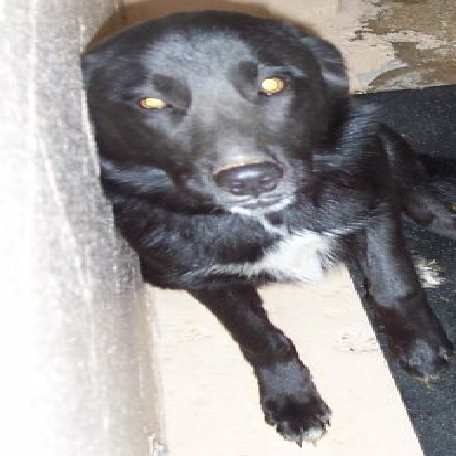

In [37]:
img_path2 = "/content/sample_data/PetImages/Dog/10000.jpg"
predict(img_path2, model_B5)
image.load_img(img_path2, target_size=(height, width))

1/1 [==============================] - 0s 93ms/step
[INFO]: Predict Classes ==> Cat With Probability 99.9849%


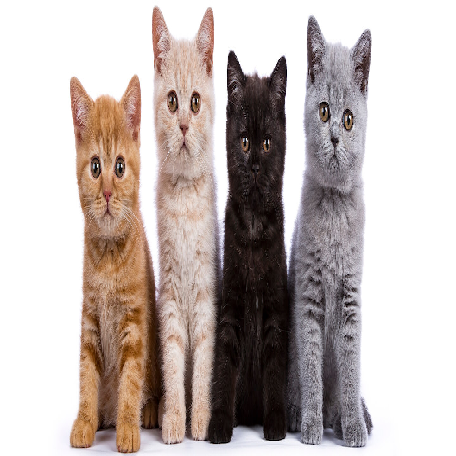

In [ ]:
img_path3 = "/content/drive/MyDrive/Hero Pedigree Cats.jpg"
predict(img_path3, model_B5)
image.load_img(img_path3, target_size=(height, width))

# Exercise

ทดลองนำภาพ นก รถยนต์ เสือ สิงโต และ สุนัขจิ้งจอก มาทำการทำนายและรายงานผลการทำนายแต่ละภาพ

1/1 [==============================] - 4s 4s/step
[INFO]: Predict Classes ==> Dog With Probability 58.4225%


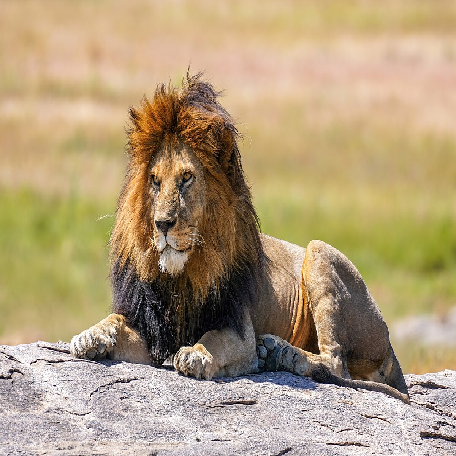

In [38]:
img_path4 = "/content/drive/MyDrive/Animal samples/Lion.jpg" # Lion #
predict(img_path4, model_B5)
image.load_img(img_path4, target_size=(height, width))

1/1 [==============================] - 1s 1s/step
[INFO]: Predict Classes ==> Cat With Probability 56.6014%


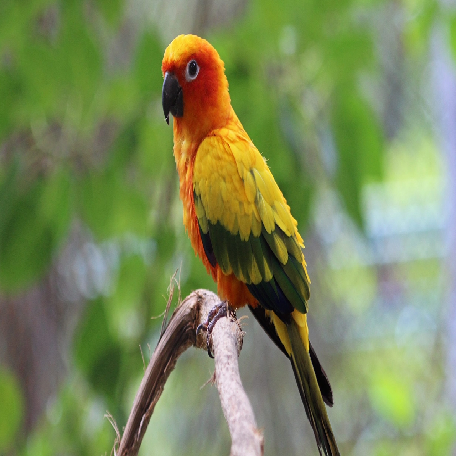

In [39]:
img_path5 = "/content/drive/MyDrive/Animal samples/Bird.jpg" # Bird #
predict(img_path5, model_B5)
image.load_img(img_path5, target_size=(height, width))

1/1 [==============================] - 1s 720ms/step
[INFO]: Predict Classes ==> Cat With Probability 50.1899%


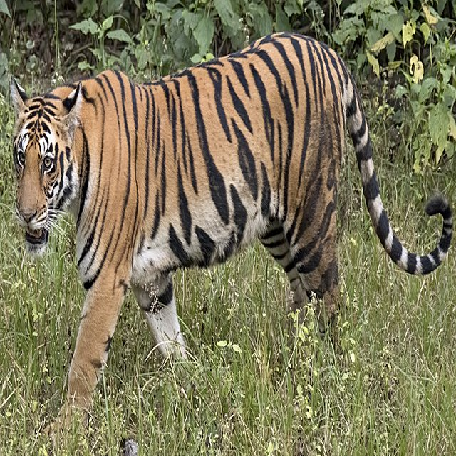

In [40]:
img_path6 = "/content/drive/MyDrive/Animal samples/Tiger.jpg" # Tiger #
predict(img_path6, model_B5)
image.load_img(img_path6, target_size=(height, width))

1/1 [==============================] - 1s 684ms/step
[INFO]: Predict Classes ==> Dog With Probability 57.7033%


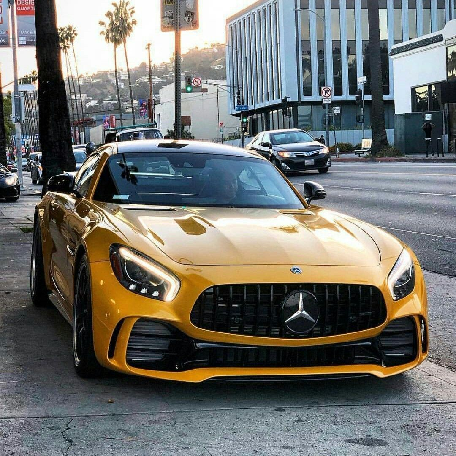

In [41]:
img_path7 = "/content/drive/MyDrive/Animal samples/Carrr.jpg" # Car #
predict(img_path7, model_B5)
image.load_img(img_path7, target_size=(height, width))

1/1 [==============================] - 1s 722ms/step
[INFO]: Predict Classes ==> Cat With Probability 53.8813%


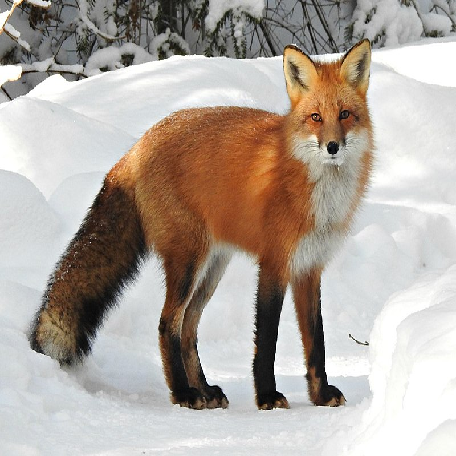

In [42]:
img_path8 = "/content/drive/MyDrive/Animal samples/Fox.jpg" # Fox #
predict(img_path8, model_B5)
image.load_img(img_path8, target_size=(height, width))

# Exercise

Print output ของ network

In [43]:
img_path = X_test['filename'].tolist()
img_x = process_image(img_path[0])  # Process the first image in the list
predictions = model_B5.predict([img_x]) # Make predictions using the model
print(f'network out is -> {predictions}')  # Print the predictions

1/1 [==============================] - 1s 696ms/step
network out is -> [[0.506024   0.49397597]]


--------------------------------------------------------------------------------------

## Evaluating Model Performance

- Confusion matrix

In [44]:
print(X_test.shape)
X_test.head()

(250, 2)


filename label
1095  /content/sample_data/PetImages/Cat/5674.jpg   Cat
1179  /content/sample_data/PetImages/Cat/3685.jpg   Cat
925   /content/sample_data/PetImages/Dog/1108.jpg   Dog
1019   /content/sample_data/PetImages/Dog/112.jpg   Dog
556   /content/sample_data/PetImages/Cat/8882.jpg   Cat

In [45]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [46]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result[0]

In [ ]:
#Predict
pred_list = list()
prob_list = list()
img_path=X_test['filename'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(label_dict[result])
    prob_list.append(predict[result])

1/1 [==============================] - 1s 1s/step


In [48]:
predict

array([0.41693646, 0.5830635 ], dtype=float32)

In [ ]:
print(len(pred_list))
print(len(prob_list))

X_test['category'] = pred_list
X_test['Prob'] = prob_list
X_test.head()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = X_test['label'].array
pred = X_test['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 99.2%
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99       125
         Dog       0.99      0.99      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



## Confusion matrix

In [50]:
#create CF
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

NameError: name 'act' is not defined

---------------------------------------

In [3]:
img_path=X_test['filename'].tolist()
img_x  = predict_image(img_path[0])
img_x


NameError: name 'X_test' is not defined

In [ ]:
image.load_img(img_path[0], target_size=(height, width))
